# Latar Belakang
Bike sharing sistem adalah generasi baru dari sistem rental sepeda tradisional dimana seluruh proses meminjam dan pengembalian sepeda dilakukan secara otomatis. dengan adanya sistem ini orang dapat rental sepeda dimana pun dan mengembalikan di manapun. Saat ini ada 500 program bike sharing di seluruh dunia yang terdiri dari 500000 sepeda. karena banyaknya sepeda tersebut sistem dapat menguranginya dengan cara prediksi jumlah sepeda yang tepat agar perawatan sepeda bisa lebih diukur dan mengurangi biaya dibandingkan harus melakukan perawatan 500000 sepeda dalam tiap hari.

## Pernyataan Masalah
**Bagaimana cara mengetahui jumlah sepeda yang dipakai di waktu tertentu agar bisa menentukan jumlah suku cadang yang diperlukan dalam perawatan sepeda?**. Informasi ini akan membantu bagian mekanik sepeda dalam menentukan jumlah sepeda yang akan dilakukan pemeriksaan rutin dan membantu mengukur jumlah sepeda yang akan dikakukan perawatan.

Sebagai seorang *data scientist*, kita akan mencoba menjawab pertanyaan berikut:

**Berapa jumlah sepeda yang diperlukan di tiap waktu tertentu?**

In [30]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import statsmodels.api as sm
from scipy.special import inv_boxcox
from sklearn.model_selection import cross_val_score, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,median_absolute_error, r2_score
import smogn
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.inspection import permutation_importance
import pickle

# Data
Untuk menjawab pertanyaan di atas, kita akan menganalisa data peserta yang sudah dikumpulkan oleh perusahaan. Dataset dapat diakses [di sini](https://drive.google.com/drive/folders/17Mw_4wSRiBB5vLLQJN137AlAbyB3CLFx). 

Dataset ini berisi informasi jumlah peminjam sepeda berdasarkan waktu dan keadaan tertentu. Ada 11 kolom di dalam dataset, yaitu:  

* dteday : date
* season : season (1: winter, 2: spring, 3: summer, 4: fall)
* hr : hour (0 to 23)
* holiday : holiday or not
* temp : normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)
* atemp : Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (only in hourly scale)
* hum : normalized humidity. The values are divided into 100 (max)
* casual : count of casual users
* registered : count of registered users
* cnt : count of total rental bikes including both casual and registered
* weathersit:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

Berikut adalah data data bike sharing

In [2]:
df=pd.read_csv("C:\\Users\\user\\Downloads\\data_bike_sharing.csv")
df

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857
...,...,...,...,...,...,...,...,...,...,...,...
12160,2012-01-25,0.75,1,0,1,0.2273,0.24,7,14,243,257
12161,2012-07-06,0.62,1,0,3,0.7424,0.78,0,39,63,102
12162,2012-02-20,0.60,2,1,1,0.2121,0.24,5,0,6,6
12163,2012-03-31,0.77,2,0,2,0.4242,0.42,2,14,55,69


## Data Understanding and Cleaning
Sebelum masuk ke dalam analisis, kita perlu mengenal dataset kita lebih jauh dalam tahapan *data understanding*. Dari proses ini, kita akan tahu anomali-anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan *data cleaning*. Setiap penangan anomali yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara *domain knowledge* maupun secara statistik.


In [3]:
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (12165, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atemp       12165 non-null  float64
 6   temp        12165 non-null  float64
 7   hr          12165 non-null  int64  
 8   casual      12165 non-null  int64  
 9   registered  12165 non-null  int64  
 10  cnt         12165 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


Dari info di atas :
- data tidak ada yang kosong (missing value)
- data kategori pada kolom weathersit, holiday dan season sudah dalam bentuk integer (tidak perlu di encoding)

In [4]:
display(df.describe(), df.describe(include='object'))

,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
count,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000
mean,0.625451,1.416934,0.029758,2.488615,0.476996,0.498185,11.519770,35.834443,153.436580,189.271023
std,0.192102,0.635937,0.169925,1.106157,0.171857,0.192492,6.931872,49.489286,151.046123,181.223903
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.470000,1.000000,0.000000,2.000000,0.333300,0.340000,6.000000,4.000000,34.000000,40.000000
50%,0.620000,1.000000,0.000000,2.000000,0.484800,0.500000,12.000000,17.000000,115.000000,142.000000
75%,0.780000,2.000000,0.000000,3.000000,0.621200,0.660000,18.000000,49.000000,220.000000,282.000000
max,1.000000,4.000000,1.000000,4.000000,1.000000,1.000000,23.000000,362.000000,876.000000,970.000000


,dteday
count,12165
unique,731
top,2012-03-02
freq,22


In [5]:
pd.set_option('display.max_colwidth', 0)
# data unik di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,dteday,731,"[2011-12-09, 2012-06-17, 2011-06-15, 2012-03-31, 2012-07-31, 2012-10-01, 2012-08-28, 2012-01-01, 2011-10-13, 2012-06-09, 2011-06-28, 2011-12-21, 2012-01-31, 2012-02-07, 2012-05-15, 2011-01-04, 2012-02-27, 2012-08-21, 2011-02-13, 2012-07-09, 2012-12-18, 2011-06-07, 2012-09-26, 2012-08-20, 2011-02-17, 2012-05-08, 2012-06-26, 2011-09-02, 2011-03-29, 2012-06-16, 2011-09-17, 2011-07-10, 2011-02-02, 2012-09-23, 2011-02-25, 2011-03-12, 2011-05-09, 2012-08-26, 2011-03-31, 2012-03-22, 2012-08-24, 2012-05-31, 2012-09-08, 2011-06-25, 2011-10-09, 2011-05-05, 2012-05-14, 2012-07-22, 2011-04-02, 2012-02-04, 2012-10-22, 2012-02-23, 2012-03-08, 2011-07-23, 2012-01-17, 2012-06-22, 2012-10-06, 2012-10-15, 2011-04-07, 2012-01-03, 2011-07-18, 2011-10-19, 2011-12-26, 2011-08-10, 2011-11-07, 2012-12-17, 2012-03-02, 2011-02-26, 2011-08-22, 2011-03-02, 2012-01-28, 2011-10-16, 2011-12-02, 2012-02-18, 2012-11-16, 2011-11-06, 2012-05-18, 2011-04-22, 2011-01-30, 2011-08-06, 2011-07-30, 2011-01-28, 2011-02-18, 2011-04-15, 2011-11-30, 2012-01-26, 2012-06-04, 2011-11-24, 2012-11-27, 2011-01-22, 2012-04-02, 2012-07-15, 2011-03-23, 2011-12-31, 2011-03-09, 2012-01-11, 2011-02-24, 2011-01-29, 2012-01-08, 2012-04-05, ...]"
1,hum,89,"[0.62, 0.64, 0.53, 0.87, 0.55, 0.72, 0.54, 0.93, 1.0, 0.24, 0.78, 0.6, 0.38, 0.52, 0.8, 0.37, 0.3, 0.83, 0.94, 0.61, 0.73, 0.35, 0.41, 0.74, 0.49, 0.33, 0.44, 0.77, 0.89, 0.88, 0.66, 0.7, 0.71, 0.63, 0.57, 0.43, 0.39, 0.45, 0.48, 0.5, 0.34, 0.19, 0.36, 0.65, 0.81, 0.79, 0.27, 0.29, 0.67, 0.75, 0.76, 0.31, 0.4, 0.28, 0.69, 0.08, 0.32, 0.51, 0.46, 0.59, 0.58, 0.23, 0.84, 0.82, 0.47, 0.18, 0.25, 0.42, 0.86, 0.0, 0.68, 0.56, 0.16, 0.21, 0.97, 0.85, 0.26, 0.22, 0.2, 0.17, 0.1, 0.15, 0.13, 0.9, 0.92, 0.96, 0.91, 0.12, 0.14]"
2,weathersit,4,"[1, 2, 3, 4]"
3,holiday,2,"[0, 1]"
4,season,4,"[4, 2, 3, 1]"
5,atemp,65,"[0.3485, 0.5152, 0.6212, 0.697, 0.4545, 0.6515, 0.2727, 0.6061, 0.4394, 0.2576, 0.5455, 0.2273, 0.6667, 0.4091, 0.3939, 0.6364, 0.5303, 0.5, 0.3636, 0.7424, 0.3333, 0.4242, 0.5758, 0.4697, 0.5909, 0.7576, 0.6818, 0.303, 0.7727, 0.1212, 0.803, 0.3182, 0.2121, 0.7879, 0.197, 0.1515, 0.4848, 0.1818, 0.3788, 0.0909, 0.2879, 0.2424, 0.5606, 0.1667, 0.7121, 0.7273, 0.0303, 0.8333, 0.8636, 0.8788, 0.1364, 0.1061, 0.8485, 0.8182, 0.0455, 0.8939, 0.9242, 0.0152, 0.0758, 0.0606, 0.9545, 0.9091, 0.0, 1.0, 0.9848]"
6,temp,50,"[0.36, 0.54, 0.62, 0.76, 0.46, 0.7, 0.26, 0.82, 0.66, 0.44, 0.58, 0.28, 0.22, 0.4, 0.38, 0.68, 0.56, 0.72, 0.52, 0.6, 0.34, 0.42, 0.64, 0.24, 0.48, 0.8, 0.32, 0.16, 0.74, 0.88, 0.3, 0.14, 0.9, 0.18, 0.06, 0.2, 0.5, 0.08, 0.78, 0.84, 0.04, 0.86, 0.12, 0.94, 0.1, 0.92, 0.96, 0.02, 0.98, 1.0]"
7,hr,24,"[16, 4, 23, 8, 18, 0, 22, 9, 5, 7, 14, 15, 21, 20, 11, 3, 13, 19, 6, 12, 1, 2, 10, 17]"
8,casual,305,"[24, 2, 17, 19, 99, 6, 20, 13, 219, 1, 11, 9, 0, 110, 51, 7, 10, 45, 30, 87, 5, 15, 60, 49, 122, 254, 81, 80, 220, 46, 36, 14, 3, 48, 31, 310, 32, 72, 26, 21, 142, 245, 16, 8, 58, 126, 47, 62, 12, 93, 27, 74, 28, 55, 50, 132, 68, 75, 29, 18, 168, 57, 61, 283, 148, 43, 4, 138, 264, 71, 121, 41, 186, 44, 39, 237, 225, 226, 224, 118, 22, 170, 162, 35, 54, 84, 200, 116, 117, 38, 53, 65, 37, 25, 196, 78, 113, 66, 33, 253, ...]"
9,registered,742,"[226, 16, 90, 126, 758, 39, 196, 27, 5, 315, 20, 278, 273, 127, 74, 48, 192, 110, 223, 652, 432, 808, 188, 119, 32, 157, 118, 141, 49, 134, 21, 227, 437, 50, 101, 23, 212, 1, 142, 171, 474, 8, 83, 233, 155, 370, 41, 43, 4, 88, 156, 99, 169, 400, 237, 7, 72, 59, 109, 228, 17, 148, 6, 26, 73, 100, 247, 91, 293, 95, 222, 383, 168, 79, 176, 146, 216, 369, 220, 22, 338, 3, 11, 123, 180, 112, 42, 181, 618, 209, 374, 467, 128, 179, 67, 104, 33, 413, 14, 19, ...]"


dari info di atas :
- pada kolom humidity terdapat angka 0, pada dasarnya humidity bisa mendekati 0 tetapi hampir tidak mungkin mencapai 0. Kelembaban nol persen berarti udara benar-benar kering dan tidak mengandung uap air sama sekali.
    * baris yang humidity 0 akan dibuang
- kolom dteday dapat diambil hari, tanggal dan bulannya, tahun tidak dibutuhkan karena belum tentu ada trend yang linear tiap bertambahnya tahun.

In [6]:
df=df[df['hum']>0]
df['dteday']=pd.to_datetime(df['dteday'])
df['tgl']=df['dteday'].dt.day
df['hari']=df['dteday'].dt.day_of_week
df['bulan']=df['dteday'].dt.month
df=df.drop(['dteday'],axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_10504\235015646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dteday']=pd.to_datetime(df['dteday'])
C:\Users\user\AppData\Local\Temp\ipykernel_10504\235015646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tgl']=df['dteday'].dt.day
C:\Users\user\AppData\Local\Temp\ipykernel_10504\235015646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

### Distribusi tiap kolom

mengecek outlier dan apakah ada data yang perlu dibuang

kolom hum tidak normal


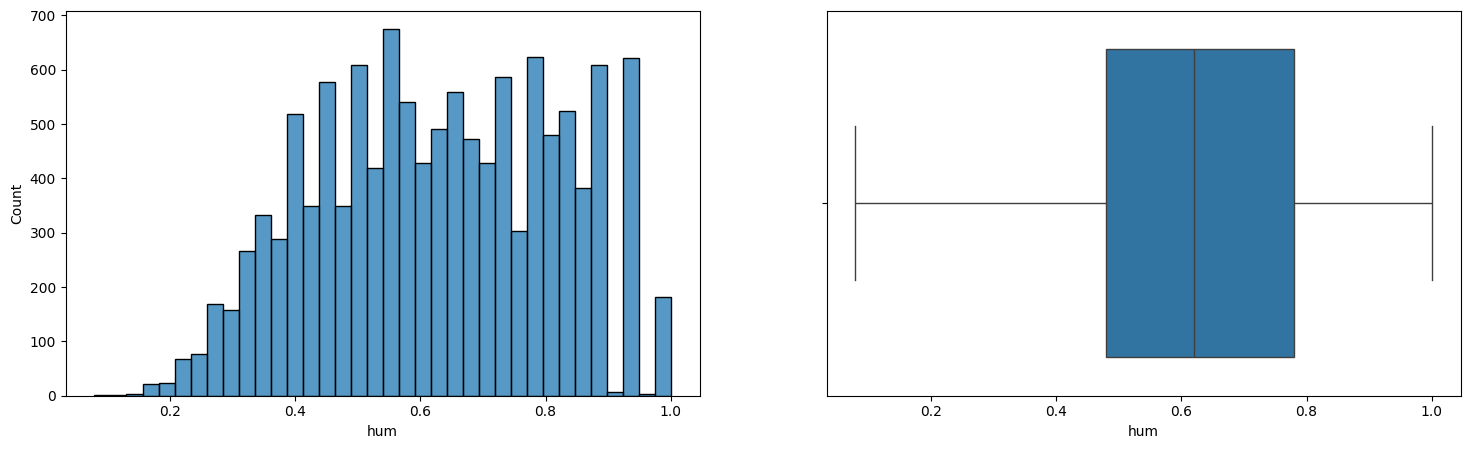

kolom weathersit tidak normal


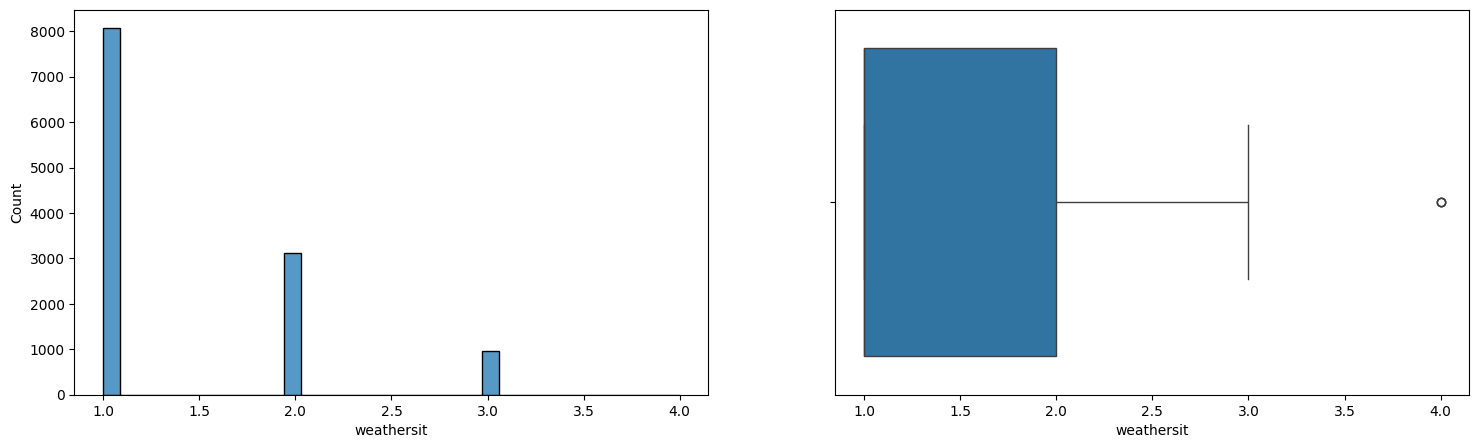

kolom holiday tidak normal


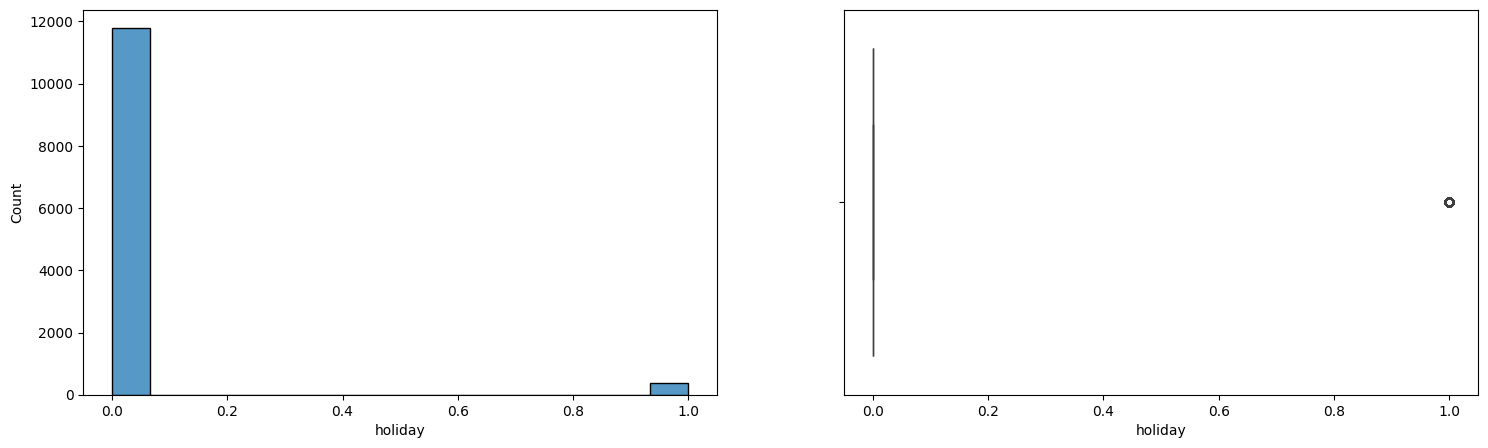

kolom season tidak normal


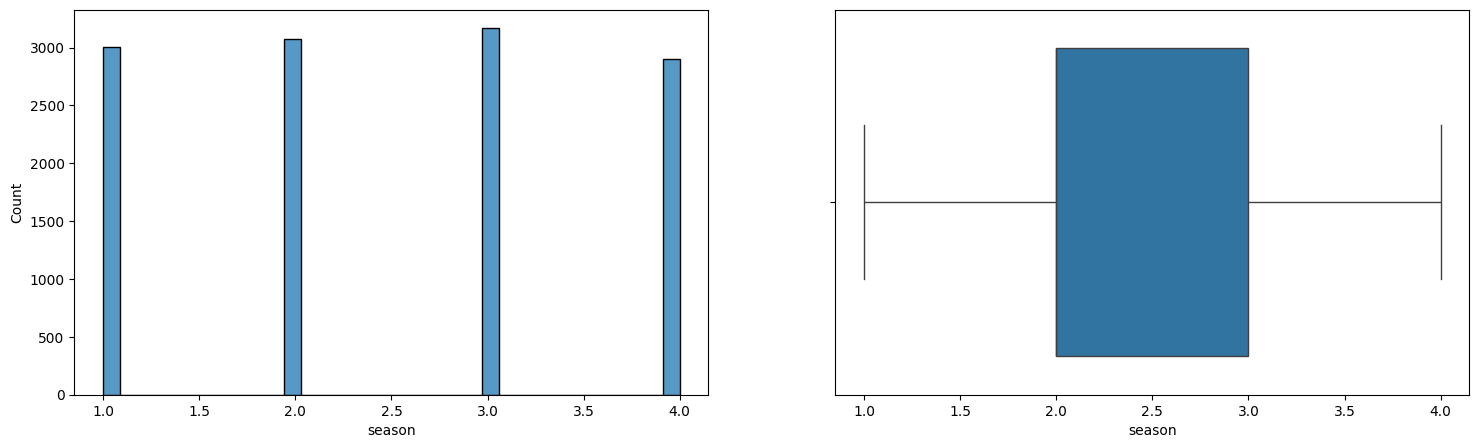

kolom atemp tidak normal


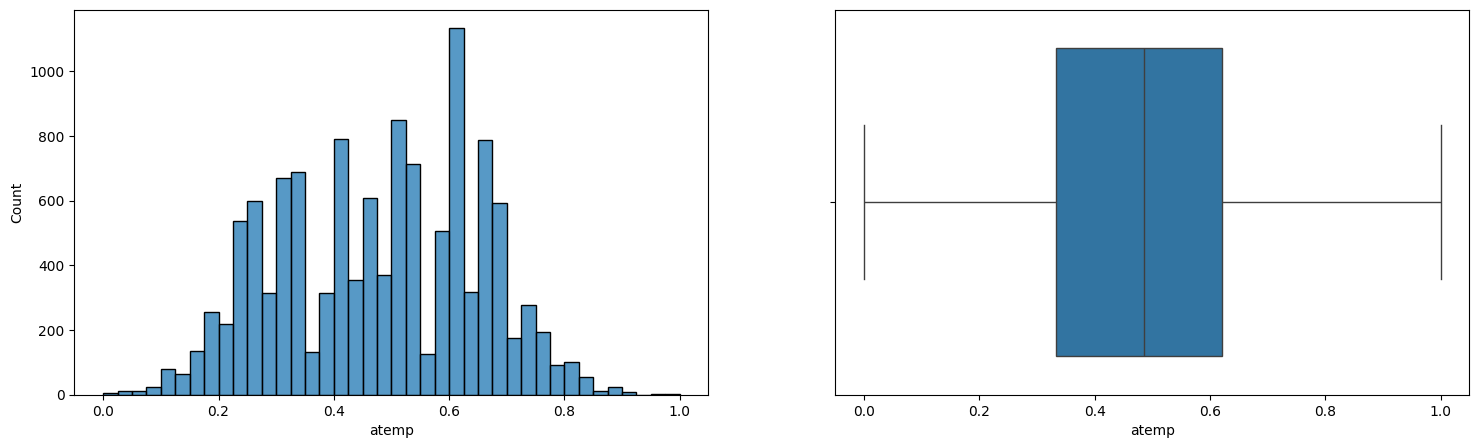

kolom temp tidak normal


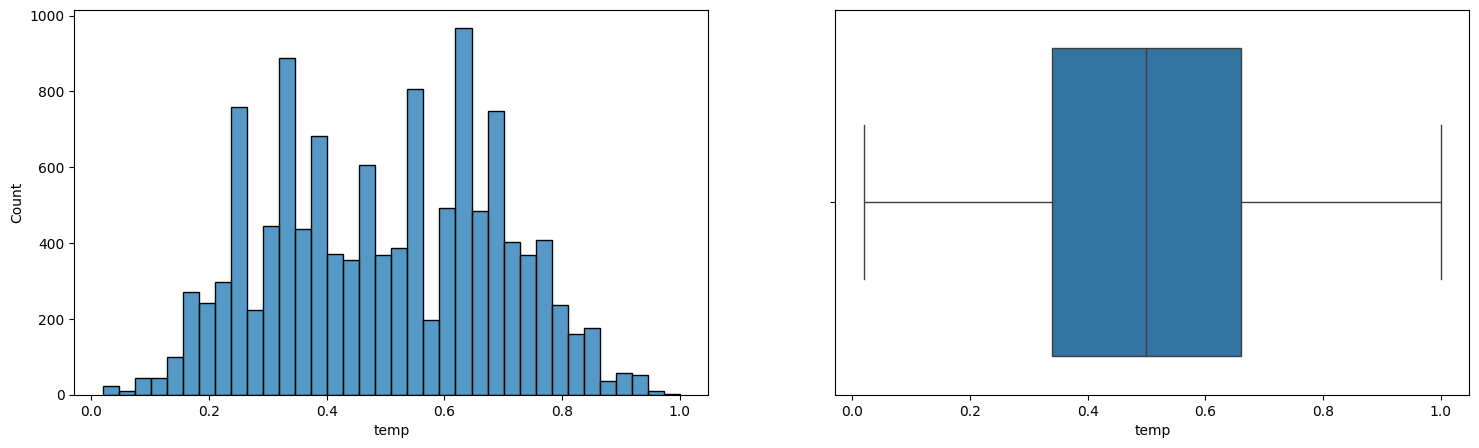

kolom hr tidak normal


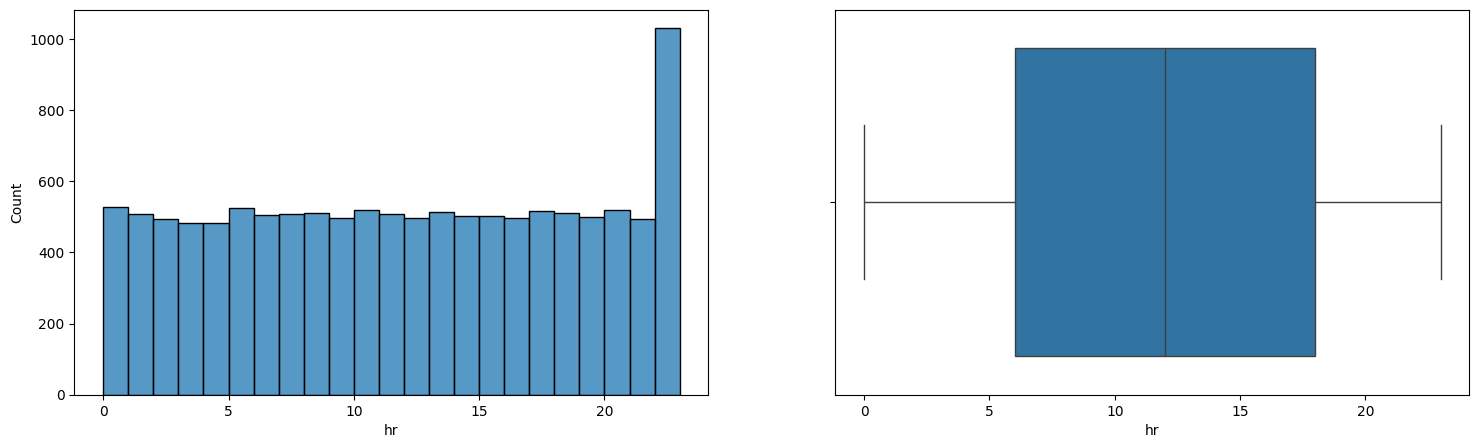

kolom casual tidak normal


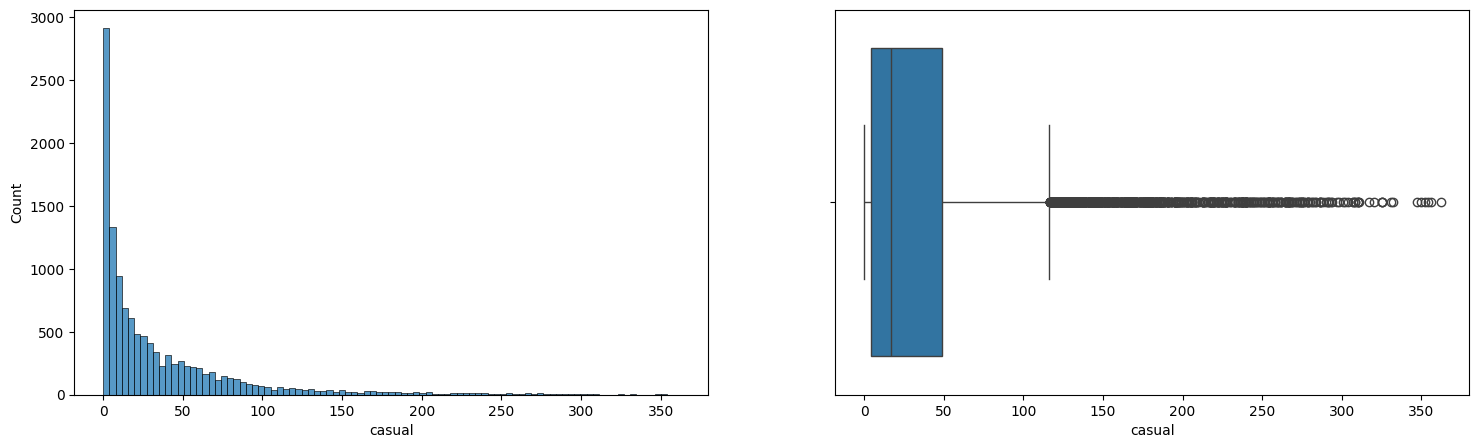

kolom registered tidak normal


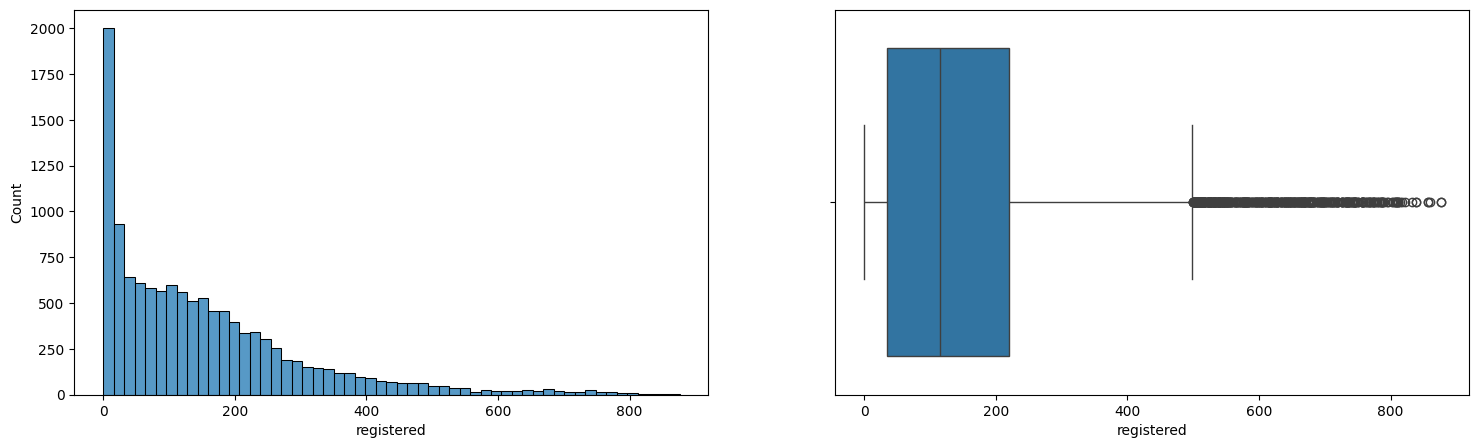

kolom cnt tidak normal


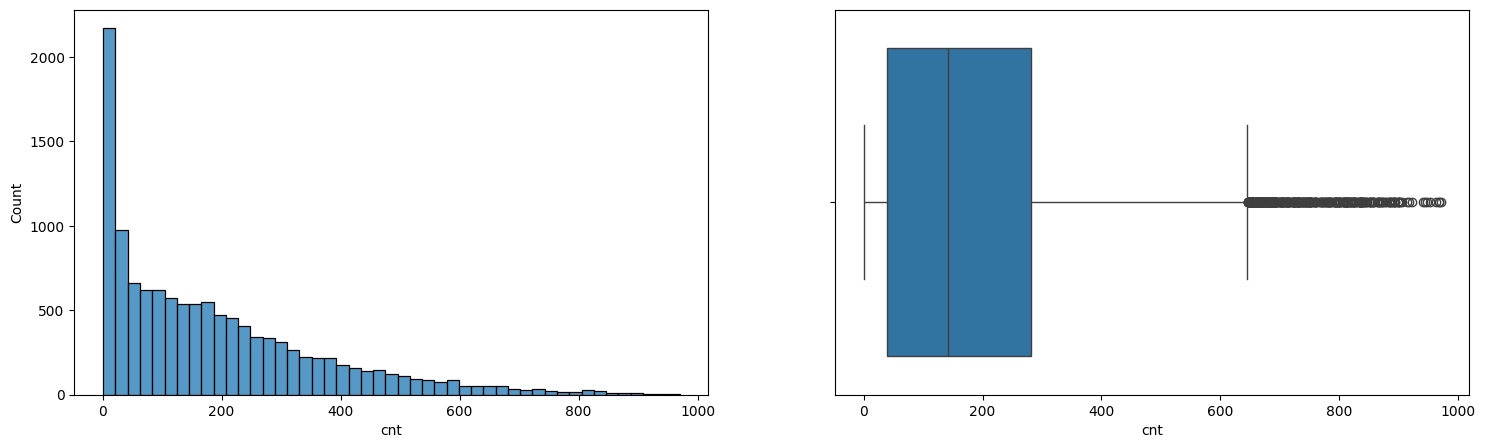

kolom tgl tidak normal


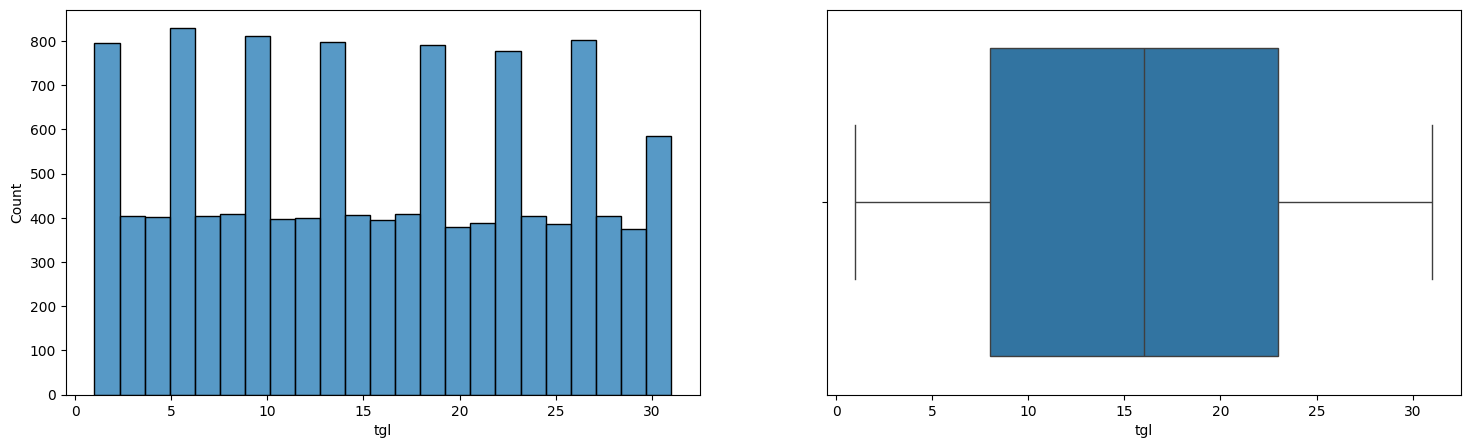

kolom hari tidak normal


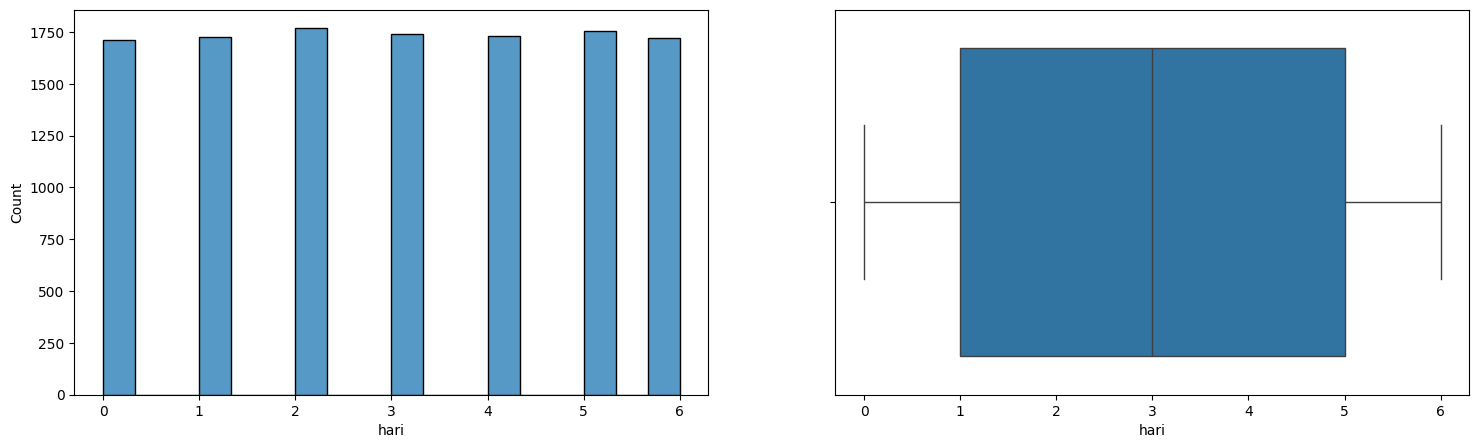

kolom bulan tidak normal


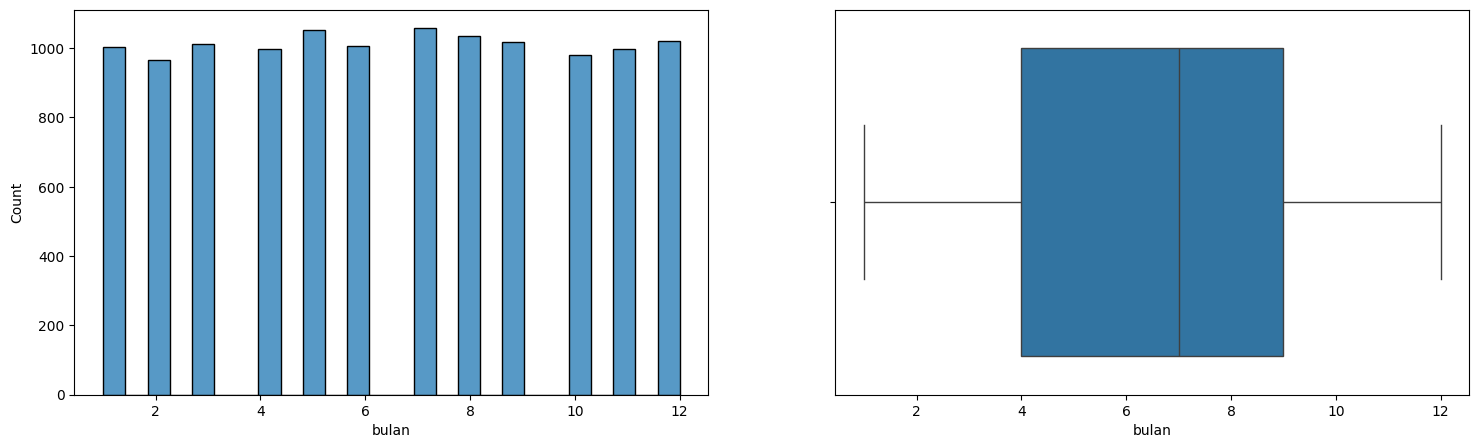

In [7]:
for i in df.columns:
    stats, pval=normaltest(df[i])
    if pval<=0.05:
        print(f'kolom {i} tidak normal')
    else: 
        print(f'kolom {i} distribusi normal')
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    sns.histplot(ax=axes[0],data=df,x=df[i])
    sns.boxplot(ax=axes[1],data=df,x=df[i])
    plt.show()

dari info diatas :
- semua kolom tidak terdistribusi normal
- pada kolom kolom kategori seperti weathersit dan holiday ada perbedaan yang jauh antara setiap kategori, jumlah yang sedikit tepa akan dipakai karena kategori tersebut bisa terjadi di tahun thun berikutnya
- pada kolom casual, registered dan cnt outlier tidak akan dibuang karena target memang akan sangat bervariasi dan model harus tangguh dalam memprediksi hal ini

korelasi

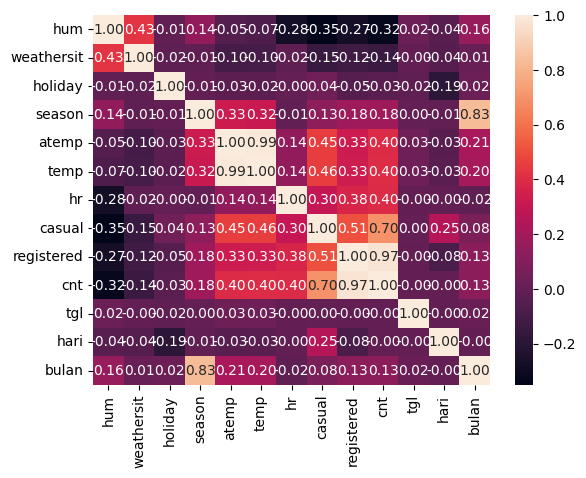

In [8]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

pada info di atas :
- ada korelasi yang sangat tinggi pada kolom atemp dan temp, salah satu kolom tersebut akan dihapus agar tidak terjadi collinearity
- ada korelasi yang sangat tinggi pada kolom season dan bulan, salah satu kolom tersebut akan dihapus agar tidak terjadi collinearity
- ada korelasi yang sangat tinggi pada kolom casual, registered dan cnt, kolom casual dan registered tersebut akan dihapus karena hasil dari penjumlahan ada di cnt dan cnt akan dijadikan kolom label

In [9]:
df=df.drop(['temp'],axis=1)
df=df.drop(['bulan'],axis=1)
df=df.drop(['casual'],axis=1)
df=df.drop(['registered'],axis=1)

In [10]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(df)

,variables,VIF
0,hum,12.992080
1,weathersit,7.307699
2,holiday,1.057303
3,season,6.992668
4,atemp,9.939441
5,hr,4.143486
6,cnt,3.148312
7,tgl,3.821465
8,hari,3.047958


nilai VIF hum diatas 10 sehingga kolom tersebut akan dihapus

In [11]:
df=df.drop(['hum'],axis=1)
calc_vif(df)

,variables,VIF
0,weathersit,4.593714
1,holiday,1.054324
2,season,6.284788
3,atemp,9.099557
4,hr,4.139751
5,cnt,2.940745
6,tgl,3.667007
7,hari,2.962798


setelah kolom hum dihapus, sudah tidak ada lagi kolom yang VIF-nya lebih dari 10

## Model

metric yang dipakai untuk mencari hasil yang bagus adalah MAPE dan MAE, karena metric tersebut akan menjelaskan besarnya persen kesalahan dari data aktualnya

cross validation

In [12]:
X=df.drop(['cnt'],axis=1)
y=df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 1122)
LR=LinearRegression()
L=Lasso()
R=Ridge()
knn=KNeighborsRegressor()
tree=DecisionTreeRegressor()
xgb=XGBRegressor()
models = [("LinearReg", LR),("Lasso", L),("Ridge", R),('knn',knn),('decision tree',tree),('xgboost',xgb)]
for model, i in models:
    scores = cross_val_score(i, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error')
    print(f'score {model} : {scores}')
    print(f'std score {model} : {scores.std()}')
    print(f'mean score {model} : {scores.mean()}')

score LinearReg : [-3.35505148 -3.22537029 -3.44103951 -3.35470348 -3.38251557]
std score LinearReg : 0.07058411857739313
mean score LinearReg : -3.351736064255642
score Lasso : [-3.35598244 -3.27328387 -3.44692602 -3.35766886 -3.39659611]
std score Lasso : 0.05701077571407448
mean score Lasso : -3.366091459956386
score Ridge : [-3.35520006 -3.22710021 -3.44206516 -3.35499242 -3.38330197]
std score Ridge : 0.07029834043237326
mean score Ridge : -3.3525319634552075
score knn : [-0.71725472 -0.73270528 -0.69818417 -0.69938116 -0.69576608]
std score knn : 0.014241755198832529
mean score knn : -0.7086582814994353
score decision tree : [-0.52546849 -0.486351   -0.5452028  -0.52628974 -0.52971545]
std score decision tree : 0.019479982388050522
mean score decision tree : -0.5226054954873925
score xgboost : [-0.5987913  -0.69441628 -0.64748329 -0.6436975  -0.64218515]
std score xgboost : 0.030306779523256774
mean score xgboost : -0.6453147053718566


Dari hasil cross validation semua model jelek, semua mean diatas 50%. Prediksi tidak dapat digunakan.

Karena hasilnya jauh dari yang diharapkan, y akan saya ubah dengan log transformation untuk mengatasi outlier. Dengan harapan hasil semakin baik.

In [13]:
y_log=np.log1p(y)
X_train, X_test, y_log_train, y_log_test = train_test_split(X,y_log,test_size = 0.2,random_state = 1122)
for model, i in models:
    scores = cross_val_score(i, X_train, y_log_train, cv = 5, scoring='neg_mean_absolute_percentage_error')
    print(f'score {model} : {scores}')
    print(f'std score {model} : {scores.std()}')
    print(f'mean score {model} : {scores.mean()}')

score LinearReg : [-0.27642925 -0.28936337 -0.27936082 -0.27148853 -0.27284724]
std score LinearReg : 0.006361496189013038
mean score LinearReg : -0.27789784199650064
score Lasso : [-0.31632251 -0.33382085 -0.32423165 -0.30748049 -0.31243006]
std score Lasso : 0.009273162060272169
mean score Lasso : -0.3188571125638875
score Ridge : [-0.27645229 -0.2894325  -0.279423   -0.27151322 -0.27289228]
std score Ridge : 0.006376095400299715
mean score Ridge : -0.2779426592217374
score knn : [-0.12138387 -0.13191122 -0.12254819 -0.11841286 -0.11657993]
std score knn : 0.005310693170133514
mean score knn : -0.12216721127129175
score decision tree : [-0.11968589 -0.11631284 -0.11981816 -0.11626163 -0.11618378]
std score decision tree : 0.0017152899758701462
mean score decision tree : -0.1176524603748657
score xgboost : [-0.08108975 -0.08640571 -0.08419285 -0.07952165 -0.08281328]
std score xgboost : 0.0023922273327075558
mean score xgboost : -0.08280464900966981


ini adalah hasil MAPE dari y yang masih belum di ubah ke angka semula (masih dalam fungsi log)

mean MAPE terbaik :
1. xgboost
2. decision tree
3. knn
4. linear regression
5. ridge
6. lasso

std MAPE terbaik :
1. xgboost
2. decision tree
3. knn
4. linear regression
5. ridge
6. lasso

model yang dipilih adalah xgboost karen nilai MAPE paling bagus dan standart deviasinya paling baik dari yang lain

model performance sebelum dituning

In [14]:
xgb.fit(X_train,y_log_train)
y_pred=xgb.predict(X_test)
y_pred_inv=np.expm1(y_pred)
y_test_inv=np.expm1(y_log_test)
print('MAPE : ',mean_absolute_percentage_error(y_test_inv,y_pred_inv))
print('MAE : ',mean_absolute_error(y_test_inv,y_pred_inv))
print('r2 score : ',r2_score(y_test_inv,y_pred_inv))

MAPE :  0.33332010858650374
MAE :  40.302255519571155
r2 score :  0.882467672056579


ini adalah hasil setelah y diubah kembali ke angka semula sebelum di log transformation, dengan xgboost bisa memprediksi dengan MAPE 33%

dengan cara menggunakan log tranformation dapat mengubah mape menjadi 33%

selanjutnya akan mencoba Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise ,penjelasan dapat diakses [di sini](https://pypi.org/project/smogn/)

In [15]:
df_coba=pd.read_csv("C:\\Users\\user\\Downloads\\data_bike_sharing.csv")
df_smogn=smogn.smoter(data=df_coba,y='cnt')

r_index: 100%|##########| 1102/1102 [00:01<00:00, 777.93it/s]
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\smogn\over_sampling.py:439: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       2012-06-11
1       2012-06-11
2       1.0       
3       1.0       
4       2.0       
       ...        
4417    2012-06-11
4418    2012-06-11
4419    120.0     
4420    457.0     
4421    55.0      
Name: 0, Length: 4422, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_new.iloc[:, j] = data_new.iloc[:, j].replace(x, cat_list[x])


In [16]:
df_coba.shape

(12165, 11)

In [17]:
df_smogn.shape

(10505, 11)

dari hasilnya data barisnya berubah

lalu kita coba memakai data yang sudah diubah ini

In [18]:
df_smogn

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2012-06-11,0.416534,2.0,0.0,2.0,0.707862,0.794400,16.0,84.0,339.0,409.0
1,2012-06-11,0.485562,1.0,0.0,2.0,0.668235,0.740403,20.0,62.0,333.0,390.0
2,2012-04-20,0.450132,1.0,0.0,2.0,0.621200,0.635497,14.0,147.0,257.0,437.0
3,2012-04-20,0.440391,1.0,0.0,2.0,0.621200,0.640000,14.0,155.0,238.0,400.0
4,2011-08-20,0.580000,1.0,0.0,3.0,0.709014,0.757963,17.0,167.0,227.0,401.0
...,...,...,...,...,...,...,...,...,...,...,...
12156,2012-10-26,0.770000,2.0,0.0,4.0,0.515200,0.540000,21.0,40.0,252.0,292.0
12157,2012-10-10,0.880000,2.0,0.0,4.0,0.454500,0.460000,3.0,0.0,6.0,6.0
12159,2012-08-16,0.540000,1.0,0.0,3.0,0.666700,0.720000,9.0,41.0,296.0,337.0
12161,2012-07-06,0.620000,1.0,0.0,3.0,0.742400,0.780000,0.0,39.0,63.0,102.0


In [19]:
df_smogn['dteday']=pd.to_datetime(df_smogn['dteday'])
df_smogn['tgl']=df_smogn['dteday'].dt.day
df_smogn['hari']=df_smogn['dteday'].dt.day_of_week
df_smogn['bulan']=df_smogn['dteday'].dt.month
df_smogn=df_smogn.drop(['dteday'],axis=1)

kolom hum tidak normal


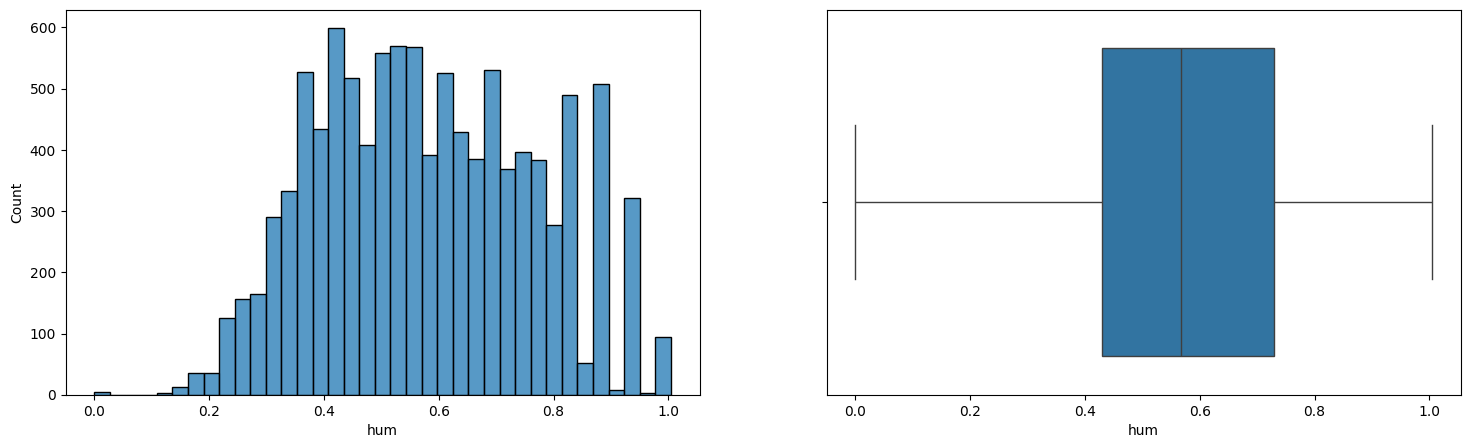

kolom weathersit tidak normal


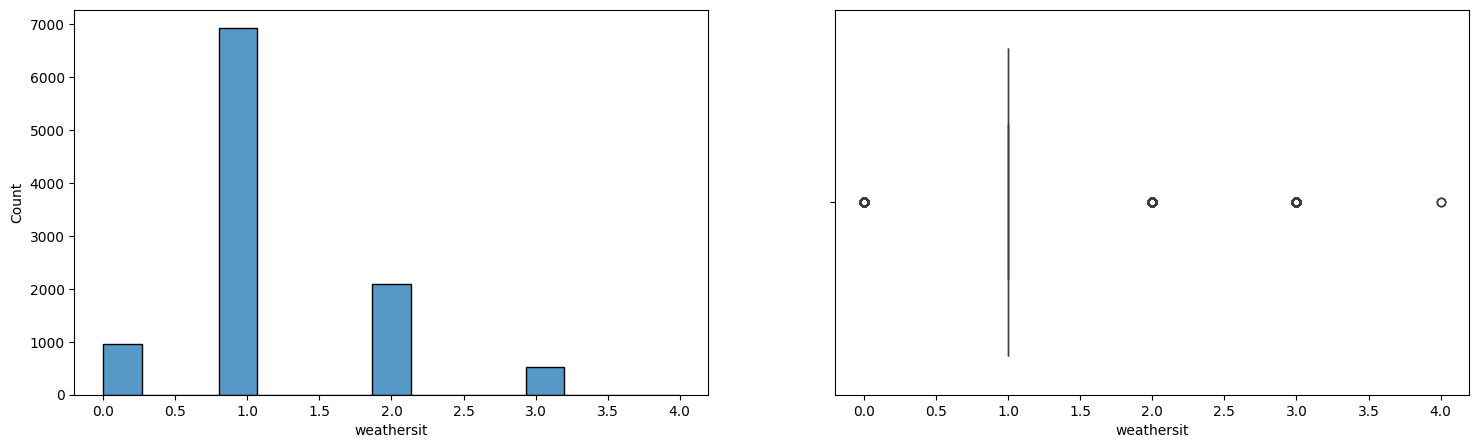

kolom holiday tidak normal


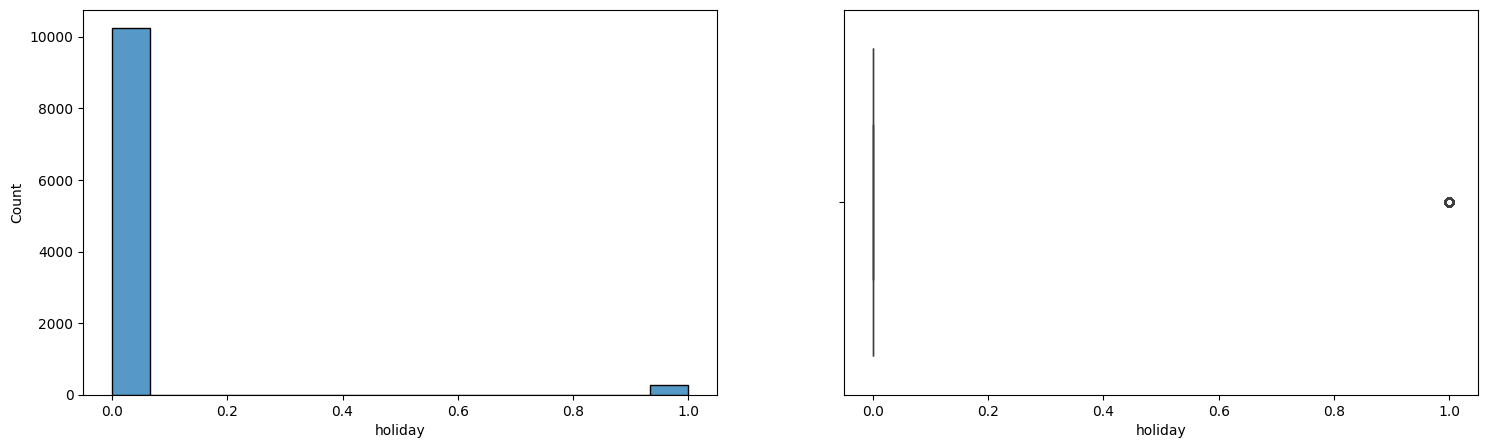

kolom season tidak normal


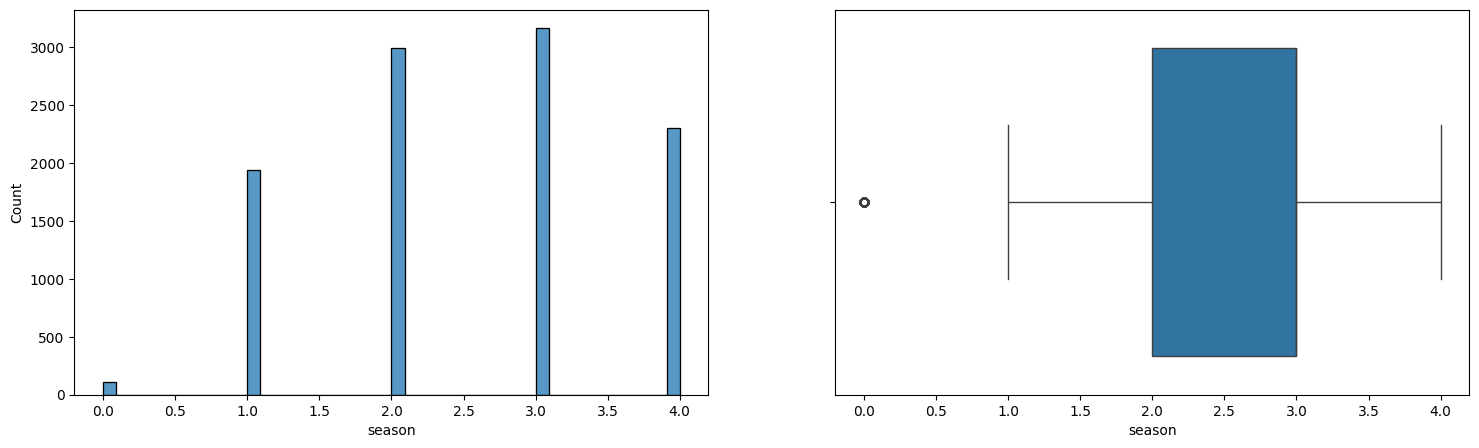

kolom atemp tidak normal


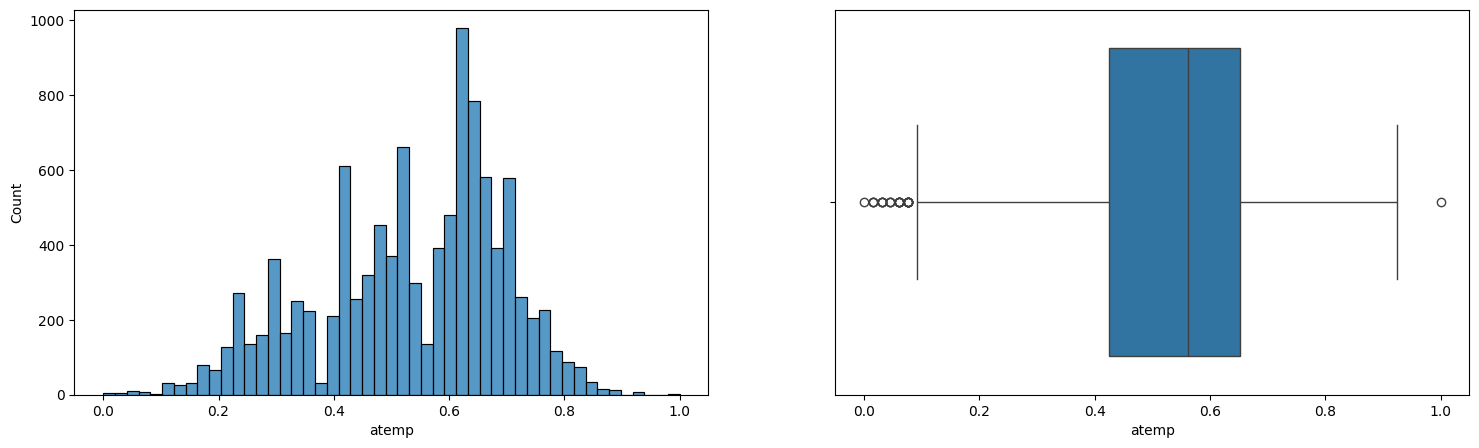

kolom temp tidak normal


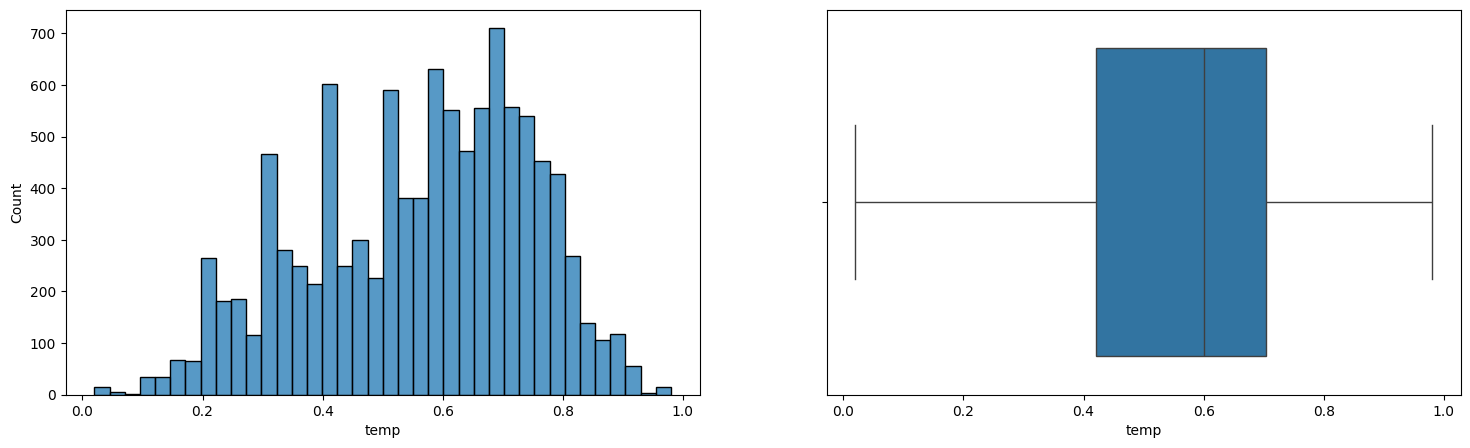

kolom hr tidak normal


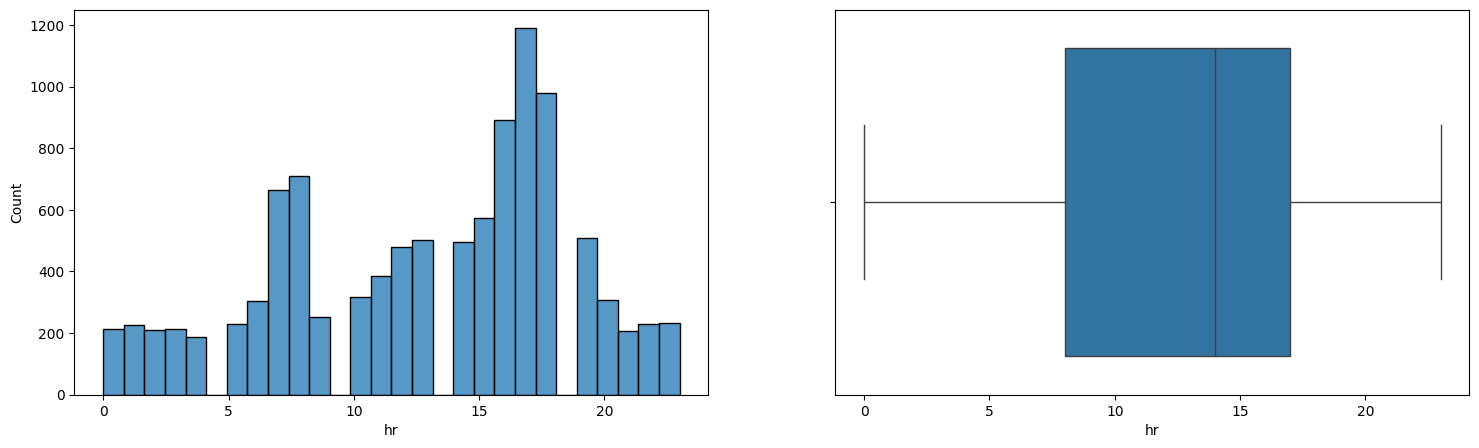

kolom casual tidak normal


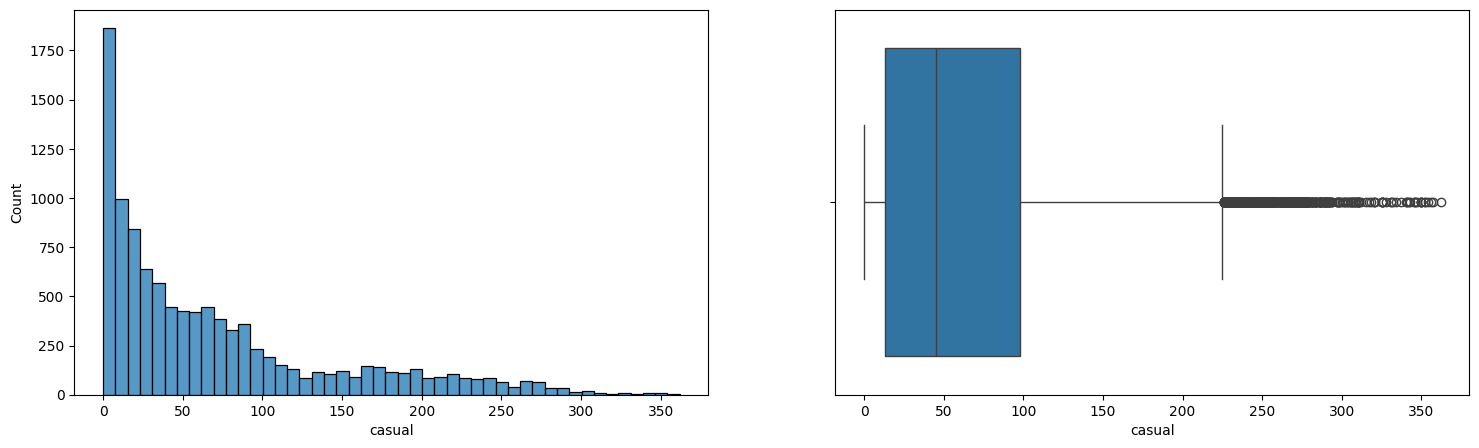

kolom registered tidak normal


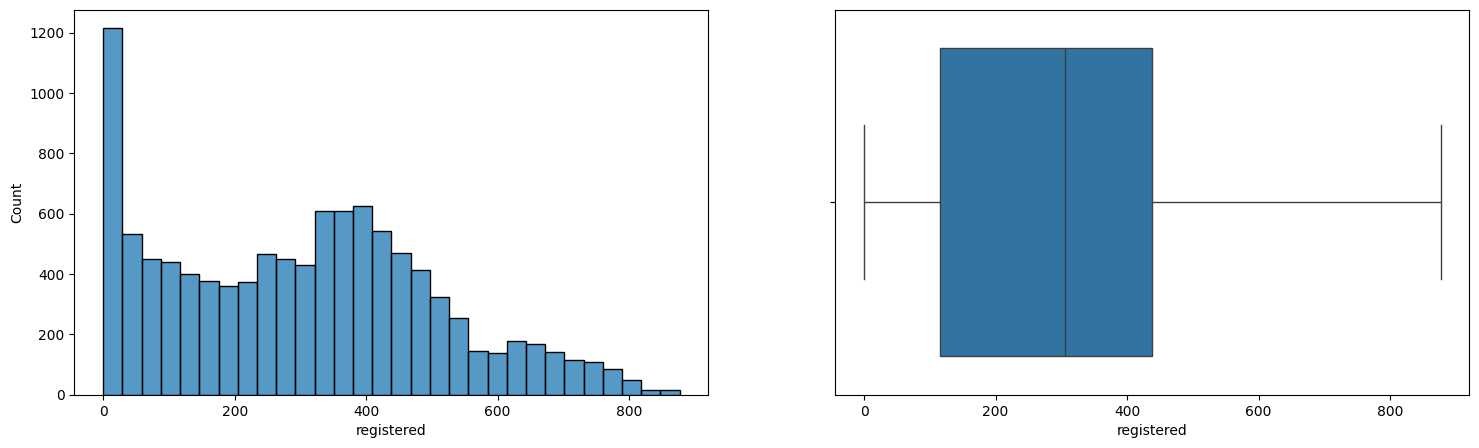

kolom cnt tidak normal


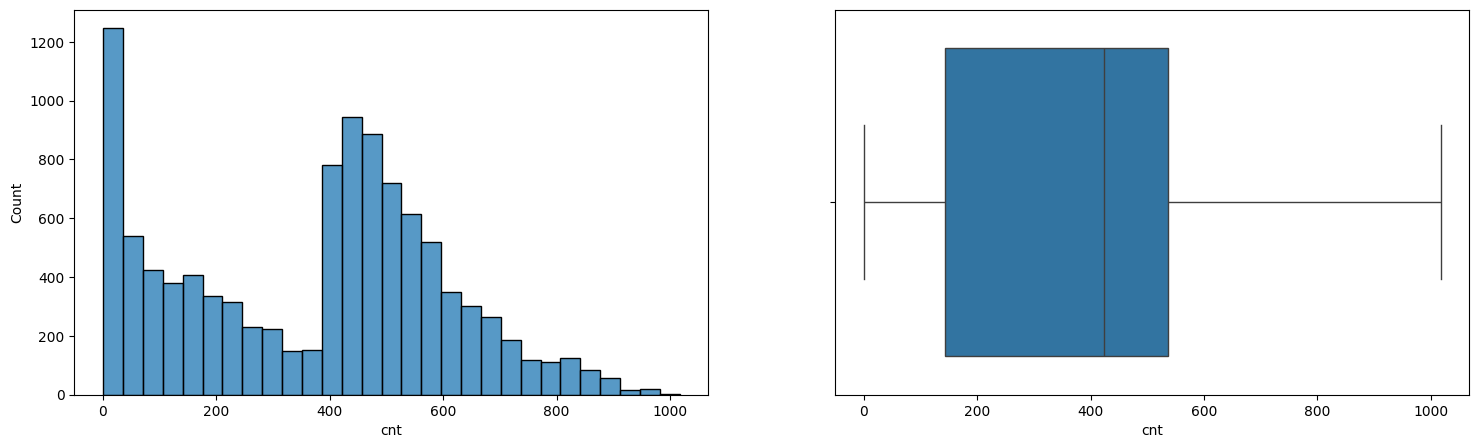

kolom tgl tidak normal


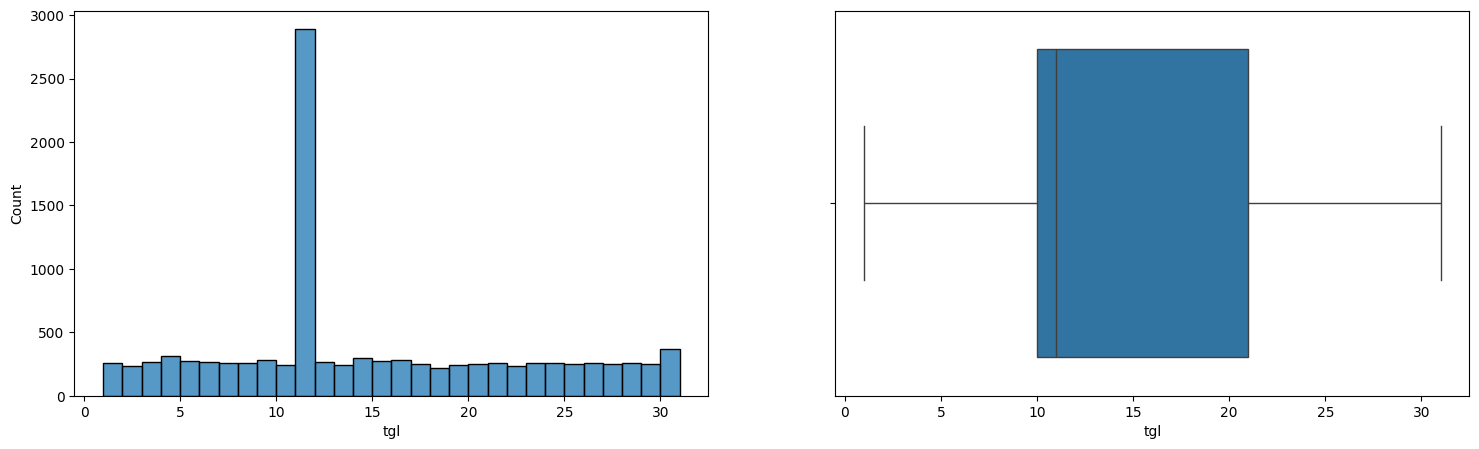

kolom hari tidak normal


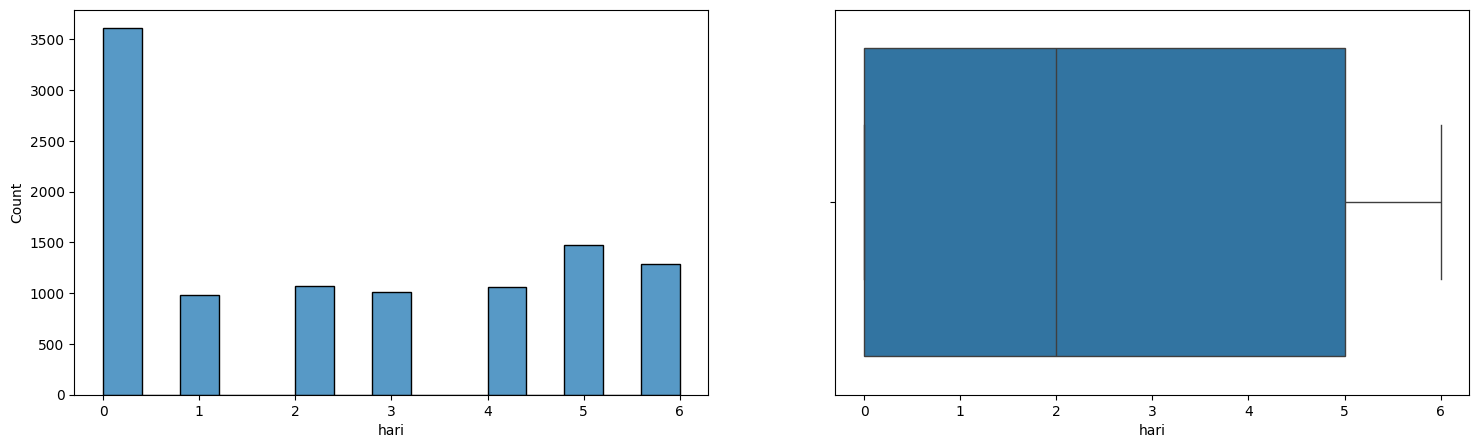

kolom bulan tidak normal


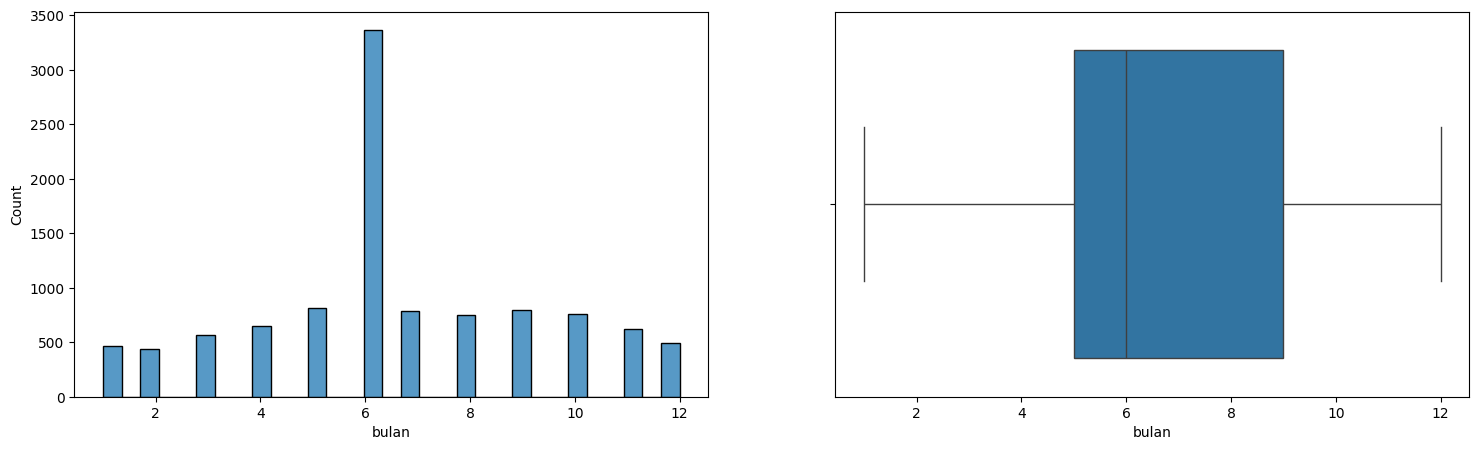

In [20]:
for i in df_smogn.columns:
    stats, pval=normaltest(df_smogn[i])
    if pval<=0.05:
        print(f'kolom {i} tidak normal')
    else: 
        print(f'kolom {i} distribusi normal')
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    sns.histplot(ax=axes[0],data=df_smogn,x=df_smogn[i])
    sns.boxplot(ax=axes[1],data=df_smogn,x=df_smogn[i])
    plt.show()

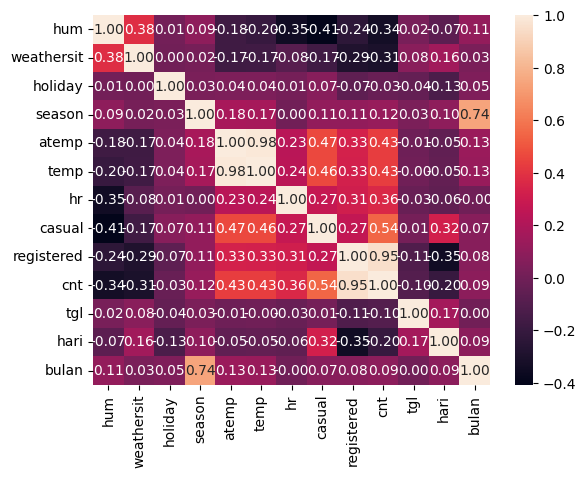

In [21]:
corr_matrix_smogn = df_smogn.corr()
sns.heatmap(corr_matrix_smogn, annot=True, fmt=".2f")
plt.show()

In [22]:
df_smogn=df_smogn.drop(['temp'],axis=1)
df_smogn=df_smogn.drop(['bulan'],axis=1)
df_smogn=df_smogn.drop(['casual'],axis=1)
df_smogn=df_smogn.drop(['registered'],axis=1)

In [23]:
def calc_vif(df_smogn):
    vif = pd.DataFrame()
    vif["variables"] = df_smogn.columns
    vif["VIF"] = [variance_inflation_factor(df_smogn.values, i) for i in range(df_smogn.shape[1])]

    return(vif)

calc_vif(df_smogn)

,variables,VIF
0,hum,9.586346
1,weathersit,5.361286
2,holiday,1.055414
3,season,7.164221
4,atemp,12.895992
5,hr,6.334390
6,cnt,5.273071
7,tgl,4.247514
8,hari,2.416947


In [24]:
df_smogn=df_smogn.drop(['atemp'],axis=1)

In [25]:
X=df_smogn.drop(['cnt'],axis=1)
y=df_smogn['cnt']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 1122)
LR=LinearRegression()
L=Lasso()
R=Ridge()
knn=KNeighborsRegressor()
tree=DecisionTreeRegressor()
xgb=XGBRegressor()
models = [("LinearReg", LR),("Lasso", L),("Ridge", R),('knn',knn),('decision tree',tree),('xgboost',xgb)]
for model, i in models:
    scores = cross_val_score(i, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error')
    print(f'score {model} : {scores}')
    print(f'std score {model} : {scores.std()}')
    print(f'mean score {model} : {scores.mean()}')

score LinearReg : [-5.18771232 -4.25358301 -3.9962102  -3.20152281 -4.7843872 ]
std score LinearReg : 0.681554990513937
mean score LinearReg : -4.284683107870803
score Lasso : [-5.1924534  -4.30987289 -4.0161701  -3.22636326 -4.84389503]
std score Lasso : 0.6817729998793839
mean score Lasso : -4.317750935101184
score Ridge : [-5.1871924  -4.25483326 -3.99673589 -3.20186126 -4.78566448]
std score Ridge : 0.6814413380334441
mean score Ridge : -4.285257458276812
score knn : [-0.63151598 -0.63378957 -0.60668512 -0.61546599 -0.65091766]
std score knn : 0.015375286686870784
mean score knn : -0.6276748657918099
score decision tree : [-0.4409855  -0.48105429 -0.45843999 -0.46829253 -0.43465702]
std score decision tree : 0.017107794579878575
mean score decision tree : -0.45668586355524665
score xgboost : [-0.69447057 -0.67635114 -0.64488139 -0.52576155 -0.60868556]
std score xgboost : 0.05974327127237594
mean score xgboost : -0.6300300424047712


hasilnya masih kurang bagus dibandingkan memakai log function

model akan tetap menggunakan log function, karena hasilnya paling bagus

setelah melihat memilih model akan dilakukan tuning

In [26]:
X=df.drop(['cnt'],axis=1)
y=df['cnt']
y_log=np.log1p(y)
X_train, X_test, y_log_train, y_log_test = train_test_split(X,y_log,test_size = 0.2,random_state = 1122)
hyperparam_space = {
    'eta':[0.01,0.05,0.1,0.15,0.2],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'max_depth':[3,4,5,6,7,8,9,10],
    'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
}

grid_search = GridSearchCV(
    xgb,
    param_grid = hyperparam_space, 
    cv = 5, 
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1 
)
grid_search.fit(X_train, y_log_train)


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.1, 0.2, ...], 'eta': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'subsample': [0.5, 0.6, ...]}"
,scoring,'neg_mean_absolute_percentage_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [27]:
print('best score',grid_search.best_score_)
print('best param',grid_search.best_params_)

best score -0.0815537541227294
best param {'colsample_bytree': 1, 'eta': 0.2, 'max_depth': 8, 'subsample': 0.9}


hasil yang di dapat dari hyperparameter tuning :
- colsample_bytree: 1
- eta: 0.2
- max_depth: 8
- subsample: 0.9

ini adalah hasil MAPE dari y yang masih belum di ubah ke angka semula (masih dalam fungsi logaritma)

Berikutnya mengetes model dan parameternya:

In [28]:
xgb=XGBRegressor(colsample_bytree=1, max_depth=8, eta=0.2, subsample=0.9)
xgb.fit(X_train,y_log_train)
y_pred=xgb.predict(X_test)
y_pred_inv=np.expm1(y_pred)
y_test_inv=np.expm1(y_log_test)
print('MAPE : ',mean_absolute_percentage_error(y_test_inv,y_pred_inv))
print('MAE : ',mean_absolute_error(y_test_inv,y_pred_inv))
print('r2 score : ',r2_score(y_test_inv,y_pred_inv))

MAPE :  0.32469725022309787
MAE :  37.52069678168295
r2 score :  0.8979715973816681


setelah tuning, perbedaan hasil MAPE :
- sebelum tuning: 0.33332010858650374
- sesudah tuning: 0.32469725022309787

limitasi model:
dari prediksi di atas berarti model mempunyai rata-rata kesalahan prediksi sebesar 38 sepeda dari hasil sebenarnya, dan rata rata kesalahan prediksi dalam persen = 32.4% dari jumlah sebenarnya

## Interpretable


 99%|===================| 12047/12151 [01:16<00:00]        

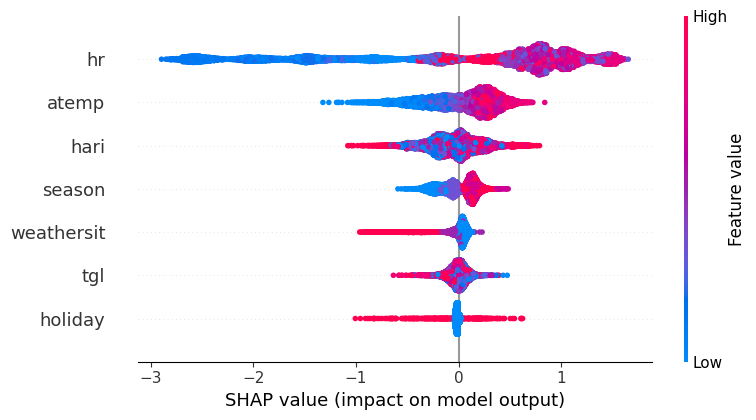

In [29]:
explainer = shap.Explainer(xgb, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

Dari hasil di atas sebagai contoh dan temuan berikut dapat dijelaskan :

- Pentingnya Fitur: Di antara fitur yang dianalisis, hr (jam) muncul sebagai fitur yang paling penting, yang menunjukkan bahwa fitur tersebut memiliki dampak paling signifikan pada prediksi. atemp mengikuti sebagai fitur terpenting kedua, sementara holiday tampaknya memiliki pengaruh paling kecil pada prediksi.
- Efek Fitur: Fitur seperti hr (jam), atemp, tgl, hari dan holiday menunjukkan ekor panjang di sebelah kanan dalam plot. Ini menunjukkan bahwa nilai fitur yang lebih tinggi untuk variabel-variabel ini memiliki dampak yang lebih besar pada prediksi. Di sisi lain semua fitur menunjukkan ekor di sebelah kiri, yang menunjukkan bahwa nilai yang lebih tinggi dari fitur-fitur ini berdampak negatif pada prediksi. Perlu dicatat bahwa semua memiliki dampak positif dan negatif pada prediksi.
- Kepadatan Nilai Fitur: Fitur-fitur tertentu, seperti hr (jam), atemp dan season, menunjukkan kepadatan titik data yang tinggi dalam range nilai fitur tertentu. Hal ini menunjukkan bahwa ada konsentrasi titik data dengan nilai fitur yang berada dalam rentang tertentu tersebut.

konklusi:
- model ini dapat memprediksi jumlah sepeda yang akan dipakai, dengan rata rata residual 38 atau dalam persentase 32.4%

saran:
- dengan adanya model ini dapat membantu mengurangi beban perawatan sepeda, karena jumlahnya penyediaan sepeda dapat diprediksi dan tidak memakai semua sepeda yang ada


In [31]:
with open('model.pickle', 'wb') as f:
    pickle.dump(xgb, f)